# Example 1 - Plot power spectra

`PyCurious` offers convenience functions to extract the radial power spectrum. This has been derived analytically by Bouligand *et al.* 2009.

In this notebook we plot the radial power spectrum using the analytical expression, and the spectrum computed from a synthetic magnetic anomaly. (This can be generated from `Bouligand_forward.py` in the `tests` directory.)

### Contents

- [Analytical solution](#Analytical-solution)
- [Radial power spectrum](#Power-spectrum-from-FFT)
- [Azimuthal power spectrum](#Azimuthal-power-spectrum)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pycurious

## Analytical solution

The analytic solution to the power spectrum is given in Equation 4 of [Bouligand *et al.*, 2009](http://doi.wiley.com/10.1029/2009JB006494),

$$\begin{align}
\Phi_{B1D}(|k|)=&C-2|k|z_t-|k|\Delta z-\beta \ln (|k|)\\
&+\ln\left[\int_0^\infty\left(\cosh(|k|\Delta z)-\cos(k_z\Delta z)\right)\left(1+\left(\frac{k_z}{|k|}\right)^2\right)^{-1-\frac{\beta}{2}}\text{d}k_z\right]
\end{align}$$

where the shape of the curve depends on 4 variables:

- $\beta$ - a fractal parameter
- $z_t$ - top of magnetic sources
- $\Delta z$ - thickness of the magnetic layer
- $C$ - a field constant

We vary each of the parameters below to observe the different shapes of the power spectra.

In [ ]:
# wavenumber range
k = np.linspace(1e-3, 3, 10000)

# Bouligand 2009 test parameters
beta = 3.0
zt = 0.305
dz = 10.0
C = 20.0

In [ ]:
k = np.linspace(1e-3, 3, 10000)

# Bouligand 2009 test parameters
beta = 3.0
zt = 0.305
dz = 10.0
C = 20.0
fig = plt.figure()
ax1 = fig.add_subplot(111)
Phi = pycurious.bouligand2009(k, beta, zt, dz, C)
#Phi -= Phi.max()
ax1.semilogx(k, Phi, label=r'$z_t$ = {} km'.format(zt))

In [ ]:
# plot Bouligand et al. 2009 curves

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(14,8),)

# vary zt
for zti in np.arange(0.0, 2.5, 0.5):
    Phi = pycurious.bouligand2009(k, beta, zti, dz, C)
    Phi -= Phi.max()
    ax1.semilogx(k, Phi, label=r'$z_t$ = {} km'.format(zti))

# vary dz
for dzi in [10., 20., 50., 100., 200.]:
    Phi = pycurious.bouligand2009(k, beta, zt, dzi, C)
    Phi -= Phi.min()
    ax2.semilogx(k, Phi, label=r'$\Delta z$ = {} km'.format(dzi))

# vary beta
for betai in np.arange(0, 5, 1):
    Phi = pycurious.bouligand2009(k, betai, zt, dz, C)
    Phi -= Phi[-1]
    ax3.semilogx(k, Phi, label=r'$\beta$ = {}'.format(betai))

ax1.set_ylim(-20, 0)
ax2.set_ylim(0, 20)

ax1.legend()
ax2.legend()
ax3.legend()

## Radial power spectrum

The radial power spectrum is computed from a square window of the magnetic anomaly. Methods to select window sizes and compute the Fast Fourier Transform (FFT) belong to the `CurieGrid` object.

`CurieGrid` achieves the following purposes:

- Upward continuation
- Reduction to the pole
- Compute the radial power spectrum using FFT

The shape of the radial power spectrum is heavily dependent on window size. Resolution of long wavelength features require large windows.

> Suggestion: use a window size **> 4 times** the maximum Curie depth.

Let's compare the computed radial power spectrum with random fractal noise from the test data that was generated from `Bouligand_forward.py` with the following parameters:

- $\beta$ = 3.0
- $z_t$ = 0.305 km
- $\Delta z$ = 10 km

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pycurious

In [2]:
# load magnetic anomaly - i.e. random fractal noise
mag_data = np.loadtxt("../../data/test_mag_data_mul.txt")

nx, ny = 305, 305

x = mag_data[:,0]
y = mag_data[:,1]
d = mag_data[:,2].reshape(ny,nx)

xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()

In [4]:
# initialise CurieGrid object
grid = pycurious.CurieGrid(d, xmin, xmax, ymin, ymax)

# pick the centroid
xpt = 0.5*(xmin + xmax)
ypt = 0.5*(ymin + ymax)

window_size = 304e3
grid = pycurious.CurieOptimise(d, xmin, xmax, ymin, ymax)

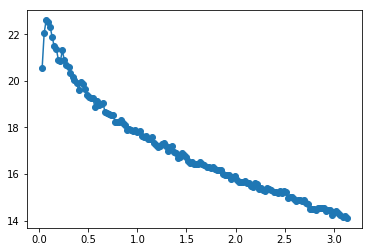

In [6]:
# compute radial power spectrum
subgrid = grid.subgrid(window_size, xpt, ypt)
k, Phi, sigma_Phi = grid.radial_spectrum(subgrid)

# plot radial power spectrum
plt.plot(k, Phi, '-o')

In [7]:


# analytic formulation
beta0, zt0, dz0, C0 = grid.optimise(window_size, xpt, ypt, krange=(k[0],k[-10]), func_flag=1)
beta1, zt1, C1 = grid.optimise(window_size, xpt, ypt, krange=(1.5,2.5), func_flag=2)
beta2, zo2, C2 = grid.optimise(window_size, xpt, ypt, krange=(0.05,0.5), func_flag=3)



In [8]:
print(zt0+dz0)
print(2*zo2-zt1)

9.08583799011594
0.5235385303284192


**Choice of taper**

The default taper is the hanning filter (see [`numpy.hanning`](#hanning) for more details), but other functions can be passed to taper, or simply set it to `None`. There is a significant offset in the power spectrum with tapering functions, however, it is the *slope* of the spectrum with wavenumber that is most important when it comes to determining Curie depth.

In [ ]:

k1, Phi1, sigma_Phi2 = grid.radial_spectrum(subgrid, taper=None)
k2, Phi2, sigma_Phi2 = grid.radial_spectrum(subgrid, taper=np.hanning)
k3, Phi3, sigma_Phi2 = grid.radial_spectrum(subgrid, taper=np.hamming)


fig = plt.figure()
ax1 = fig.add_subplot(111, xlabel="wavenumber (rad/km)", ylabel="radial power spectrum")
ax1.plot(k1, Phi1, '-o', label='none')
ax1.plot(k2, Phi2, '-o', label='hanning')
ax1.plot(k3, Phi3, '-o', label='hamming')
ax1.legend()
plt.show()

## Azimuthal power spectrum

The azimuthal spectrum computes the FFT on a square window that is polarised at a range of radii. This is useful to explore linear trends in the magnetic anomaly that may align with a particular foliation or strike orientation.

```python
azimuthal_spectrum(subgrid, theta=5.0)
```

`theta` controls the thickness of each azimuth (in degrees).

In [ ]:
k, Phi, theta = grid.azimuthal_spectrum(subgrid, theta=20.0)

fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel=r'azimuth $\theta$', xlabel='wavenumber (rad/km)')
im1 = ax1.pcolor(k, theta, Phi)
fig.colorbar(im1, label='radial power spectrum')

Plotting each azimuth on the power spectrum-wavenumber axis highlights the different in slope for different polarisations of the magnetic anomaly.

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111, xlabel="wavenumber (rad/km)", ylabel="radial power spectrum")

for i, angle in enumerate(theta):
    ax1.plot(k, Phi[i], label=r'$\theta = {}^\circ$'.format(angle))

ax1.legend(bbox_to_anchor=(1,1))
plt.show()